# Improving Twitter's Retention and User Growth Rate (Hypothesis Tests)

## Setting up the environment

In [22]:
from rpy2.robjects.packages import importr
import rpy2.robjects.numpy2ri
import rpy2
import os
import numpy as np
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import figure
import seaborn as sns
import pingouin
from scipy.stats import chisquare
matplotlib.rcParams['figure.figsize'] = (12, 7)
sns.set()

# import packages from R
os.environ["R_HOME"] = r"C:\Program Files\R\R-4.2.1"
rpy2.robjects.numpy2ri.activate()
stats = importr('stats')  # R package for fisher's exact test


In [2]:
twitter_ex = pd.read_csv('Understanding Twitter Experiences.csv')
pd.set_option('display.max_columns', None)
twitter_ex
twitter_ex.columns = twitter_ex.columns.str.replace('\'', '')
twitter_ex.columns


Index(['StartDate', 'EndDate', 'Status', 'Progress', 'Duration (in seconds)',
       'Finished', 'RecordedDate', 'ResponseId', 'DistributionChannel',
       'UserLanguage',
       'Q1 - In the past 7 days, how many times did you use Twitter?',
       'Q2 - Please select Twitter.',
       'Q3 - What do you use Twitter for? - Selected Choice',
       'Q3_8_TEXT - What do you use Twitter for? - Other - Text',
       'Q4 - What do you think about Twitter?',
       'Q5 - How would you describe the kind of content you see on Twitter?',
       'Q6 - How do you feel when using Twitter?',
       'Q7 - Does what you feel, think about, and see on Twitter affect how you use it?',
       'Q8 - How much control do you have over your Twitter feed?',
       'Q9 - How do you manage your Twitter feed to suit your preference(s)? - Selected Choice',
       'Q9_7_TEXT How do you manage your Twitter feed to suit your preference(s)? - Other - Text',
       'Q10 - What is your gender'],
      dtype='object')

In [3]:
# excluding the invalid responses
twitter_ex_update = twitter_ex.loc[(twitter_ex['Q1 - In the past 7 days, how many times did you use Twitter?'].isin(['3 or more times', '1 -2 times'])) & (twitter_ex['Q2 - Please select Twitter.'] == 'Twitter'), :]
len(twitter_ex_update)

44

## Chi-square Test of Good Fit

#### Alpha = 0.05 (5%)

In [4]:
# Create dataframe for my assumptions
my_assumptions = pd.DataFrame({'content_assumed': ['Good', 'Average', 'Delightful', 'Poor', 'Terrible'], 'feelings_assumed':
                       ['Somewhat happy', 'Neither happy nor unhappy', 'Extremely happy', 'Somewhat unhappy', 'Extremely unhappy'], 'assumed_proportions': [0.1375, 0.1375, 0.1375, 0.1375, 0.45]})
my_assumptions['samples_assumed'] = my_assumptions['assumed_proportions'] * len(twitter_ex_update)
my_assumptions


,content_assumed,feelings_assumed,assumed_proportions,samples_assumed
0,Good,Somewhat happy,0.1375,6.05
1,Average,Neither happy nor unhappy,0.1375,6.05
2,Delightful,Extremely happy,0.1375,6.05
3,Poor,Somewhat unhappy,0.1375,6.05
4,Terrible,Extremely unhappy,0.4500,19.80


In [5]:
def real_assumed_vis(observed_df, assumed_col):
    '''visualise comparison between observation and assumptions'''
    plt.bar(observed_df['observed'], observed_df['sample_observed'])
    plt.scatter(my_assumptions[assumed_col], my_assumptions['samples_assumed'], color='red')
    plt.show()

### Hypothesis 1: The proportion of people whose experience with Twitter’s content is awful will be 45% or more of the sample (Test of Good Fit)

H0: 45% of the sample will think Twitter’s content is terrible

H1: Less than 45% of the sample will think Twitter’s content is terrible

In [6]:
# Q5 counts - real
content_observed = twitter_ex_update['Q5 - How would you describe the kind of content you see on Twitter?'].value_counts(
    ).rename_axis('observed').reset_index(name='sample_observed')
content_observed['proportion_observed'] = round(
    content_observed['sample_observed'] / len(twitter_ex_update), 2)
content_observed


,observed,sample_observed,proportion_observed
0,Good,20,0.45
1,Average,13,0.30
2,Delightful,8,0.18
3,Terrible,2,0.05
4,Poor,1,0.02


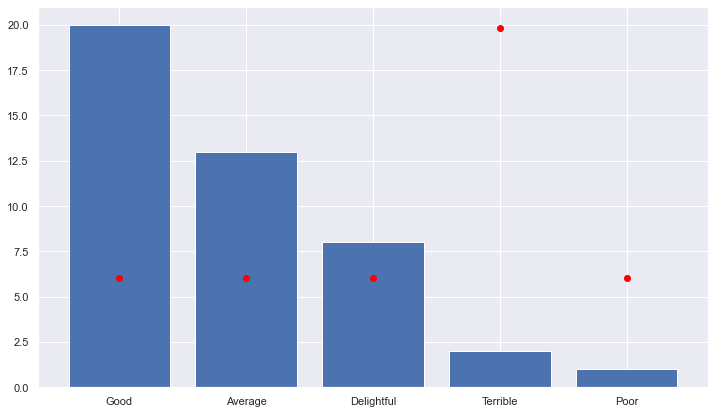

In [7]:
real_assumed_vis(content_observed, 'content_assumed') # red dots are the assumed frequencies while the blue ars are the observed frequencies

In [8]:
# Chi-Test
chisquare(f_obs=content_observed['sample_observed'], f_exp=my_assumptions['samples_assumed'])


Power_divergenceResult(statistic=61.339761248852156, pvalue=1.5166539849490286e-12)

The p-value is less than 0.05. I have to <strong>reject</strong> my null hypothesis (H0)

### Hypothesis 2: The proportion of people whose feelings about Twitter are extremely unhappy will be 45% or more of the sample (Test of Good Fit)

H0: 45% of the sample will report that using Twitter makes them feel extremely unhappy

H1: Less than 45% of the sample will report that using twitter makes them extremely unhappy


In [9]:
# Q5 counts - real
feelings_observed = twitter_ex_update['Q6 - How do you feel when using Twitter?'].value_counts().rename_axis('observed').reset_index(name='sample_observed')
feelings_observed['proportion_observed'] = round(
    feelings_observed['sample_observed'] / len(twitter_ex_update), 2)
feelings_observed.loc[4] = ['Extremely unhappy', 0, 0.0]  # add extremely unhappy row.
feelings_observed

,observed,sample_observed,proportion_observed
0,Somewhat happy,23,0.52
1,Neither happy nor unhappy,12,0.27
2,Extremely happy,5,0.11
3,Somewhat unhappy,4,0.09
4,Extremely unhappy,0,0.00


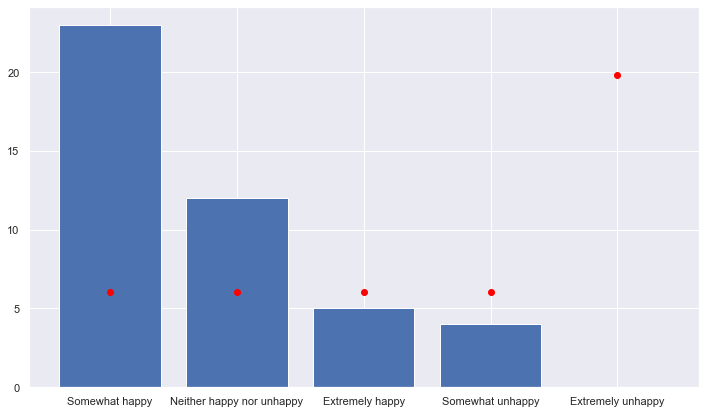

In [10]:
real_assumed_vis(feelings_observed, 'feelings_assumed') # red dots are the assumed frequencies while the blue ars are the observed frequencies

In [11]:
# Chi-Test - Q6
chisquare(f_obs=feelings_observed['sample_observed'], f_exp=my_assumptions['samples_assumed'])



Power_divergenceResult(statistic=74.01652892561982, pvalue=3.2165699344662703e-15)

The p-value is less than 0.05. I have to <strong>reject</strong> my null hypothesis (H0).

## Fisher's Exact Test (Test of Independence)

In [12]:
def cat_vis(ind_var, dep_var):
    '''visualising categories'''
    vis_data = twitter_ex_update.groupby(
        ind_var)[dep_var].value_counts(normalize=True)
    vis_data.unstack().plot(kind='bar', stacked=True)


def fisherexact(ind_var, dep_var):
    '''fisher exact test for two variables'''
    test_data = pd.crosstab(twitter_ex_update[ind_var], twitter_ex_update[dep_var]).to_numpy()
    res = stats.fisher_test(test_data)
    return f'p-value: {res[0][0]}'


### Hypothesis 3: The experience people have with Twitter and how people feel about Twitter are significantly associated with how people use Twitter. 

#### How people describe Twtter's content (Q5) & Influence on Twitter usage (Q7): Test of Independence

H0: Q5 and Q7 are independent

H1: Q5 and Q7 are not independent (they are associated)

Q5 is the independet variable (explanatory category) (x)

Q7 is the dependent variable (response category) (y)

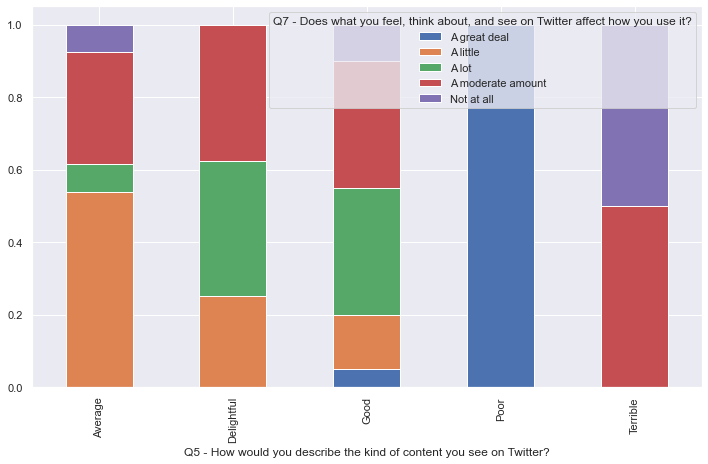

In [13]:
cat_vis('Q5 - How would you describe the kind of content you see on Twitter?',
        'Q7 - Does what you feel, think about, and see on Twitter affect how you use it?')

In [14]:
# q5 & q7 test of independence
fisherexact('Q5 - How would you describe the kind of content you see on Twitter?',
            'Q7 - Does what you feel, think about, and see on Twitter affect how you use it?')



'p-value: 0.12356410488607474'

The p-value is more than 0.05 which means I have to <strong>fail to reject</strong> the null hypothesis (H0) that says that Q5 and Q7 are independent. From this I can deduce that the kind of content people encounter on Twitter has little influence on how they use Twitter. 

#### Twitter Content (Q5) & Feelings about Twitter (Q6): Test of Independence

H0: Q5 and Q6 are independent

H1: Q5 and Q6 are not independent (they are associated)

Q6 is the independet variable (explanatory category) (x)

Q5 is the dependent variable (response category) (y)



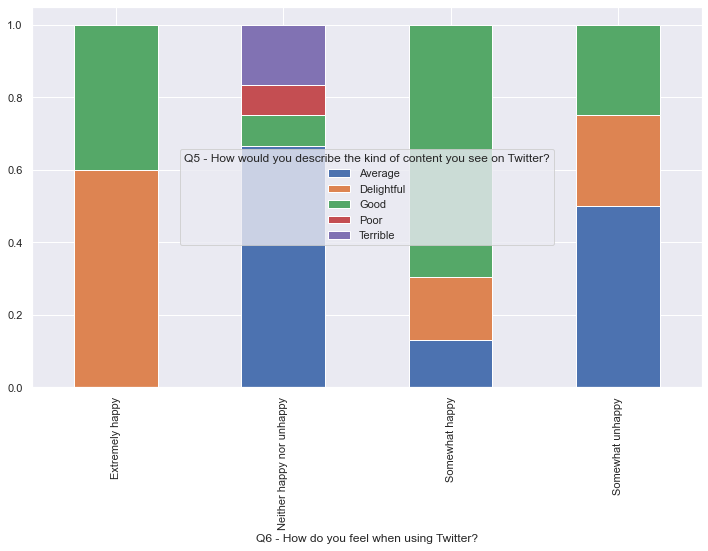

In [15]:
cat_vis('Q6 - How do you feel when using Twitter?', 'Q5 - How would you describe the kind of content you see on Twitter?')

In [16]:
fisherexact('Q6 - How do you feel when using Twitter?', 'Q5 - How would you describe the kind of content you see on Twitter?')

'p-value: 6.288589989448793e-05'

But how people feel when using Twitter is associated with how they describe Twitter's content. Here the p-value is less than 0.05 which means I have to <strong>reject</strong> my null hypothesis (h0).  

#### Feelings about Using Twitter (Q6) & Influence on Twitter Usage (Q7): Test of Independence

H0: Q6 and Q7 are independent

H1: Q6 and Q7 are not independent (they are associated)

Q6 is the independet variable (explanatory category) (x)

Q7 is the dependent variable (response category) (y)



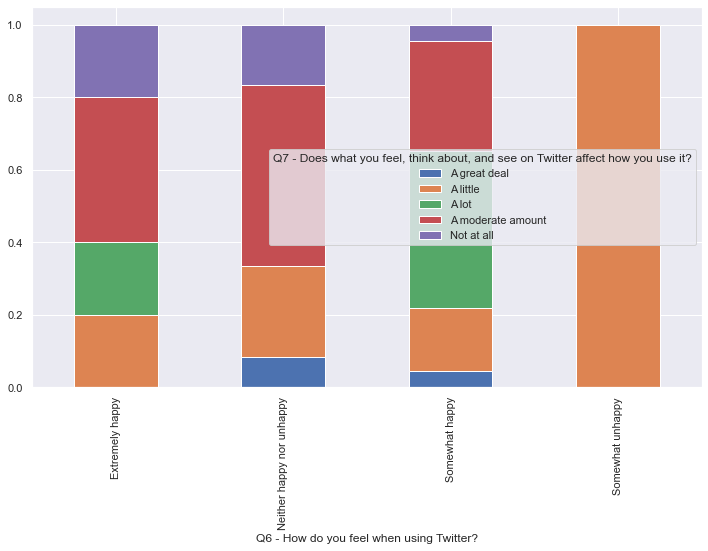

In [17]:
cat_vis('Q6 - How do you feel when using Twitter?',
        'Q7 - Does what you feel, think about, and see on Twitter affect how you use it?')

In [18]:
#q6 & q7

fisherexact('Q6 - How do you feel when using Twitter?',
            'Q7 - Does what you feel, think about, and see on Twitter affect how you use it?')


'p-value: 0.022218694341742604'

In addition, how people feel about Twitter is significantly associated with how they use Twitter. The p-value here is less than 0.05 (0.04) which means I have to <strong>reject</strong> the null that says that Q6 and Q7 are independent. From this I can deduce that there is an association between Q6 and Q7 which means how people feel about twitter influences how they would use it.

### Hypothesis 4: There is a significant association between one’s ability to control their Twitter feed (Q8) and how one feels about Twitter when using it (Q6) 

H0: Feelings about Twitter (Q6) and the amount of control one has over their twitter feed (Q8) are independent

H1: Feelings about Twitter (Q6) and the amount of control one has over their twitter feed (Q8) are not independent (they are associated)



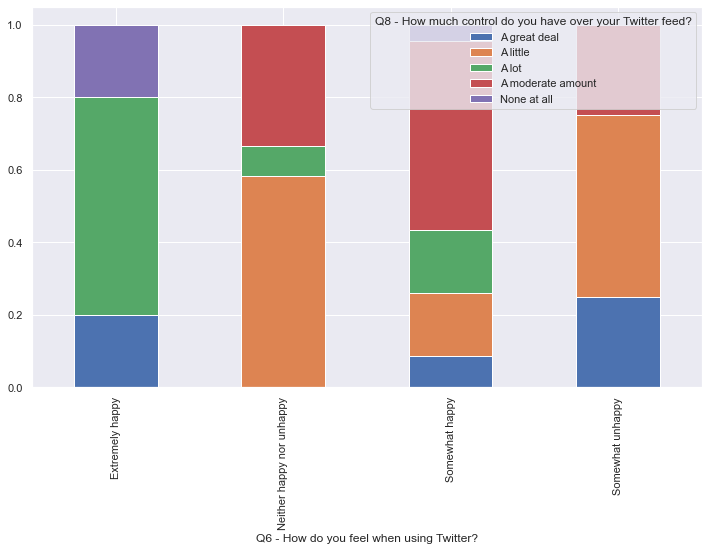

In [20]:
cat_vis('Q6 - How do you feel when using Twitter?',
        'Q8 - How much control do you have over your Twitter feed?')

In [21]:
# q6 & q10 test of independence

fisherexact('Q6 - How do you feel when using Twitter?',
            'Q8 - How much control do you have over your Twitter feed?')


'p-value: 0.0146724994884357'

The p-value is less than 0.05 which means I have to <strong>reject</strong> the null that says that Q6 and Q8 are independent. From this I can deduce that the amount of control one has on their twitter feed is significantly related with how they feel about it.